In [1]:
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from xarray.util.generate_ops import inplace

warnings.simplefilter(action='ignore', category=FutureWarning)
import dataframe_image as dfi
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
import dask.array as da
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64608,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:64620,Total threads: 4
Dashboard: http://127.0.0.1:64625/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:64611,


# 1. Load data

In [32]:
# Check and create 'data' and 'results' folders if they do not exist
data_folder = 'data'
results_folder = 'results'

if not os.path.exists(data_folder):
    os.makedirs(data_folder)
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Assign folder paths to variables for later use
DATA_DIR = data_folder
RESULTS_DIR = results_folder

# Load cleaned data 
# Columns to load
cols = ['timestamp_REF','UnixTimeStamp','TobiiTimeStamp','Auto_TobiiTimeStamp',
        'uid', 'Condition','Event','eye_theta_h','eye_theta_v','streeringDegree',
        'CarYaw_degrees','CarRoll_degrees', 'CarPitch_degrees','RelativeHeadYaw_degrees',
        'RelativeHeadPitch_degrees', 'RelativeHeadRoll_degrees']
df = dd.read_csv(os.path.join(DATA_DIR, 'EEDA_cleaned.csv'), usecols=cols).compute()
df.head()

,timestamp_REF,UnixTimeStamp,TobiiTimeStamp,uid,Auto_TobiiTimeStamp,Condition,Event,streeringDegree,eye_theta_h,eye_theta_v,CarYaw_degrees,CarPitch_degrees,CarRoll_degrees,RelativeHeadYaw_degrees,RelativeHeadPitch_degrees,RelativeHeadRoll_degrees
0,1970-01-01 02:56:39.665039062+00:00,1.630156e+09,10599.665039,017397ca31114170abc2ff61a217460b,10599.665039,Autonomous,NoEv,-42.106627,-1.611504,-3.784578,74.761305,0.847228,0.280716,3.099670,0.210684,5.025472
1,1970-01-01 02:56:39.686523437+00:00,1.630156e+09,10599.686523,017397ca31114170abc2ff61a217460b,10599.686523,Autonomous,NoEv,-42.106627,-1.539683,-3.805523,74.720284,0.850861,0.273172,2.883921,-0.249197,4.662842
2,1970-01-01 02:56:39.699218750+00:00,1.630156e+09,10599.686523,017397ca31114170abc2ff61a217460b,10599.699219,Autonomous,NoEv,-42.106627,-1.539683,-3.805523,74.720284,0.850861,0.273172,2.883921,-0.249197,4.662842
3,1970-01-01 02:56:39.721679687+00:00,1.630156e+09,10599.721680,017397ca31114170abc2ff61a217460b,10599.721680,Autonomous,NoEv,-42.132882,-1.098943,-3.900335,74.650599,0.830270,0.260069,2.911437,-0.207017,4.638311
4,1970-01-01 02:56:39.743164062+00:00,1.630156e+09,10599.743164,017397ca31114170abc2ff61a217460b,10599.743164,Autonomous,NoEv,-42.132882,-0.994679,-3.919528,74.621516,0.819260,0.252394,2.890011,-0.181404,4.623228


# 2. Data resampling
Data will be resampled to 50Hz

In [33]:
# Ensure datetime for timestamp reference
df['timestamp_REF'] = pd.to_datetime(df.Auto_TobiiTimeStamp, utc=True, unit='s', origin='unix')

In [34]:
# Function to calculate time passed in seconds from the first timestamp
def calculate_time_passed(group):
    first_timestamp = group['timestamp_REF'].min()
    group['time'] = (group['timestamp_REF'] - first_timestamp).dt.total_seconds().round(2)
    return group

df = df.groupby('uid').apply(calculate_time_passed).reset_index(drop=True)
df.head()

,timestamp_REF,UnixTimeStamp,TobiiTimeStamp,uid,Auto_TobiiTimeStamp,Condition,Event,streeringDegree,eye_theta_h,eye_theta_v,CarYaw_degrees,CarPitch_degrees,CarRoll_degrees,RelativeHeadYaw_degrees,RelativeHeadPitch_degrees,RelativeHeadRoll_degrees,time
0,1970-01-01 02:56:39.665039062+00:00,1.630156e+09,10599.665039,017397ca31114170abc2ff61a217460b,10599.665039,Autonomous,NoEv,-42.106627,-1.611504,-3.784578,74.761305,0.847228,0.280716,3.099670,0.210684,5.025472,0.00
1,1970-01-01 02:56:39.686523437+00:00,1.630156e+09,10599.686523,017397ca31114170abc2ff61a217460b,10599.686523,Autonomous,NoEv,-42.106627,-1.539683,-3.805523,74.720284,0.850861,0.273172,2.883921,-0.249197,4.662842,0.02
2,1970-01-01 02:56:39.699218750+00:00,1.630156e+09,10599.686523,017397ca31114170abc2ff61a217460b,10599.699219,Autonomous,NoEv,-42.106627,-1.539683,-3.805523,74.720284,0.850861,0.273172,2.883921,-0.249197,4.662842,0.03
3,1970-01-01 02:56:39.721679687+00:00,1.630156e+09,10599.721680,017397ca31114170abc2ff61a217460b,10599.721680,Autonomous,NoEv,-42.132882,-1.098943,-3.900335,74.650599,0.830270,0.260069,2.911437,-0.207017,4.638311,0.06
4,1970-01-01 02:56:39.743164062+00:00,1.630156e+09,10599.743164,017397ca31114170abc2ff61a217460b,10599.743164,Autonomous,NoEv,-42.132882,-0.994679,-3.919528,74.621516,0.819260,0.252394,2.890011,-0.181404,4.623228,0.08


In [35]:
def plot_sampling_rate_and_time_diff(df, title='Original', uid_col='uid', timestamp_col='timestamp_REF', time_col='time'):
    """
    Plot sampling rate and time difference over time for a given dataframe.
    Args:
        df (pd.DataFrame): The dataframe to plot.
        title (str): The title of the plot.
        uid_col (str): The column name of the uid.
        timestamp_col (str): The column name of the timestamp.
        time_col (str): The column name of the time.
    """
    data = df.copy()
    data[timestamp_col] = pd.to_datetime(data[timestamp_col], errors='coerce')
    data = data.sort_values([uid_col, timestamp_col])

    data['time_diffs'] = data.groupby(uid_col)[timestamp_col].diff().dt.total_seconds()
    data.loc[data['time_diffs'] <= 0, 'time_diffs'] = np.nan
    data['sampling_rate'] = 1.0 / data['time_diffs']

    # Plot 1: Sampling rate per participant
    fig1, ax1 = plt.subplots(figsize=(16, 6))
    sns.boxplot(x=uid_col, y='sampling_rate', data=data, ax=ax1)
    ax1.set_title(f'{title} Sampling Rate by UID')
    ax1.set_xlabel('UID')
    ax1.set_ylabel('Sampling Rate (samples/sec)')
    ax1.tick_params(axis='x', rotation=80)
    fig1.tight_layout()

    # Plot 2: Time difference over time
    fig2, ax2 = plt.subplots(figsize=(6, 2))
    sns.scatterplot(x=time_col, y='time_diffs', data=data, s=10, ax=ax2)
    ax2.set_title(f'{title} Time Difference Over Time')
    ax2.set_xlabel('Time from start (s)')
    ax2.set_ylabel('Δt (s)')
    fig2.tight_layout()

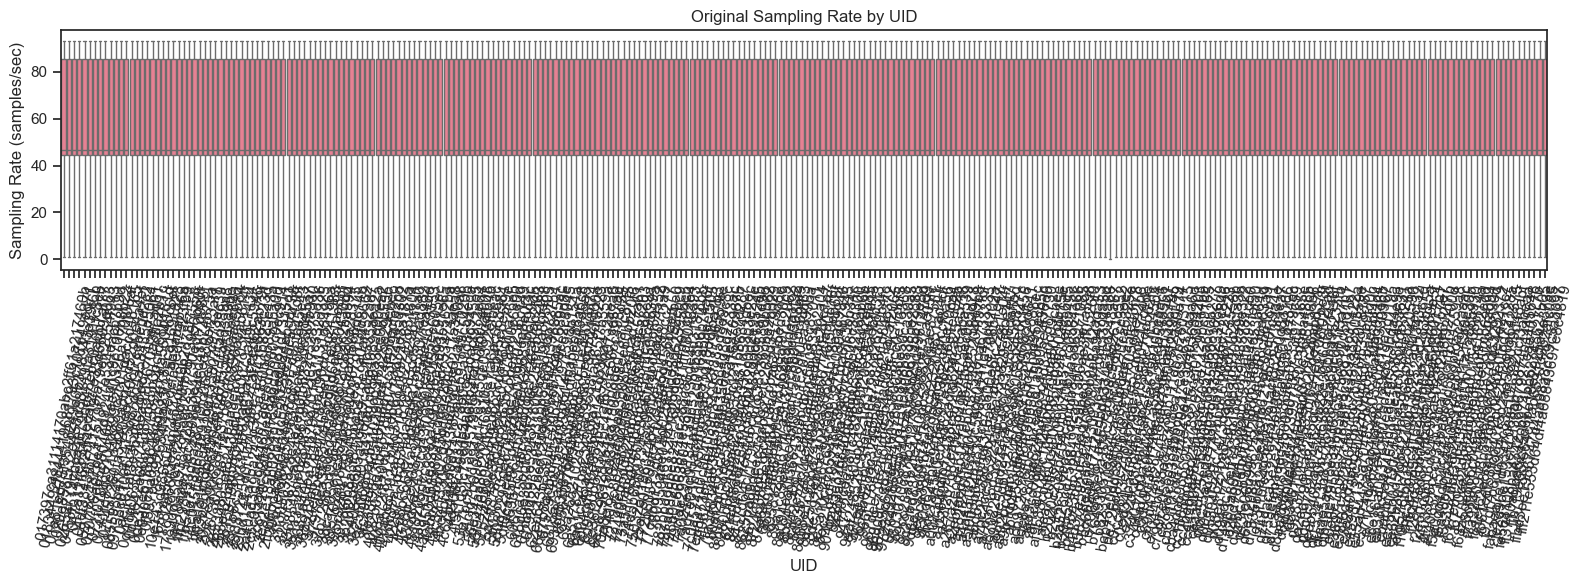

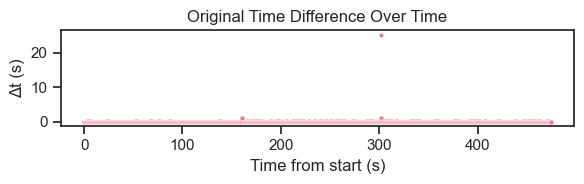

In [36]:
# Visualize original sampling rate and timestamp differences over time
plot_sampling_rate_and_time_diff(df)

## 2.1 Choose data subset
We keep only variables to use for analysis

In [37]:
# Drop unnecessary columns
df = df[['timestamp_REF','uid','Event','eye_theta_h', 'eye_theta_v',
                'CarYaw_degrees', 'CarPitch_degrees','CarRoll_degrees',
                'RelativeHeadYaw_degrees', 'RelativeHeadPitch_degrees',
                'RelativeHeadRoll_degrees', 'streeringDegree','Condition']]
df.head()

,timestamp_REF,uid,Event,eye_theta_h,eye_theta_v,CarYaw_degrees,CarPitch_degrees,CarRoll_degrees,RelativeHeadYaw_degrees,RelativeHeadPitch_degrees,RelativeHeadRoll_degrees,streeringDegree,Condition
0,1970-01-01 02:56:39.665039062+00:00,017397ca31114170abc2ff61a217460b,NoEv,-1.611504,-3.784578,74.761305,0.847228,0.280716,3.099670,0.210684,5.025472,-42.106627,Autonomous
1,1970-01-01 02:56:39.686523437+00:00,017397ca31114170abc2ff61a217460b,NoEv,-1.539683,-3.805523,74.720284,0.850861,0.273172,2.883921,-0.249197,4.662842,-42.106627,Autonomous
2,1970-01-01 02:56:39.699218750+00:00,017397ca31114170abc2ff61a217460b,NoEv,-1.539683,-3.805523,74.720284,0.850861,0.273172,2.883921,-0.249197,4.662842,-42.106627,Autonomous
3,1970-01-01 02:56:39.721679687+00:00,017397ca31114170abc2ff61a217460b,NoEv,-1.098943,-3.900335,74.650599,0.830270,0.260069,2.911437,-0.207017,4.638311,-42.132882,Autonomous
4,1970-01-01 02:56:39.743164062+00:00,017397ca31114170abc2ff61a217460b,NoEv,-0.994679,-3.919528,74.621516,0.819260,0.252394,2.890011,-0.181404,4.623228,-42.132882,Autonomous


In [38]:
# Define custom aggregator functions
aggregation_dict = {
        'Event': 'first',
        'eye_theta_h': 'mean',
        'eye_theta_v': 'mean',
        'CarYaw_degrees': 'mean',
        'CarPitch_degrees': 'mean',
        'CarRoll_degrees': 'mean',
        'RelativeHeadYaw_degrees':'mean',
        'RelativeHeadPitch_degrees':'mean',
        'RelativeHeadRoll_degrees':'mean',
        'streeringDegree':'mean',
        'Condition':'first',
    }

In [39]:
df.columns

Index(['timestamp_REF', 'uid', 'Event', 'eye_theta_h', 'eye_theta_v',
       'CarYaw_degrees', 'CarPitch_degrees', 'CarRoll_degrees',
       'RelativeHeadYaw_degrees', 'RelativeHeadPitch_degrees',
       'RelativeHeadRoll_degrees', 'streeringDegree', 'Condition'],
      dtype='object')

## 2.2 Resampling

Run the commented code in case you suspect of repeated samples (two samples with the same timestamp)

In [40]:
# Define the columns you want to process
# columns_to_process = ['eye_theta_h', 'eye_theta_v', 'CarYaw_degrees',
#                       'CarPitch_degrees', 'CarRoll_degrees',
#                       'RelativeHeadYaw_degrees', 'RelativeHeadPitch_degrees',
#                       'RelativeHeadRoll_degrees']

# # Function to handle repeated samples on a column
# df = df.groupby('uid').apply(
#     lambda group: group.assign(
#         **{col: group[col].where(~group[col].duplicated(keep='first'), np.nan) for col in columns_to_process}
#     )
# ).reset_index(drop=True)

# # Interpolate NaN values linearly for the specified columns
# df[columns_to_process] = df[columns_to_process].interpolate(method='linear')

# # Display the cleaned DataFrame
# df.head()

In [41]:
# Define the resampling function
def resample_data_by_uid(df):
    """
    Resamples data from high frequency to 50Hz for each UID.
    Numerical columns are aggregated, and non-numerical are transformed.
    """
    # Group by 'uid' and apply the resampling
    resampled_groups = df.groupby('uid').apply(
        # Convert columns of object dtype to their inferred types
        lambda group: group.set_index('timestamp_REF').resample('20L').agg(aggregation_dict).infer_objects(copy=False).interpolate(method='linear').ffill().bfill()
    ).reset_index()

    return resampled_groups

# Only delete df after resampling, and check if df exists before calling the function
if 'df' in locals():
    # Resample the data to 50 Hz for each UID
    resampled_df = resample_data_by_uid(df)
    # Drop the original DataFrame to free up memory
    del df
    print("Your df was deleted to free memory, now you are working with 'resampled_df'.")
else:
    print("df is not defined. Please make sure your original DataFrame is loaded before resampling.")

Your df was deleted to free memory, now you are working with 'resampled_df'.


In [42]:
# Calculate time passed in seconds from the first timestamp
resampled_df = resampled_df.groupby('uid').apply(calculate_time_passed).reset_index(drop=True)
resampled_df.head()

,uid,timestamp_REF,Event,eye_theta_h,eye_theta_v,CarYaw_degrees,CarPitch_degrees,CarRoll_degrees,RelativeHeadYaw_degrees,RelativeHeadPitch_degrees,RelativeHeadRoll_degrees,streeringDegree,Condition,time
0,017397ca31114170abc2ff61a217460b,1970-01-01 02:56:39.660000+00:00,NoEv,-1.611504,-3.784578,74.761305,0.847228,0.280716,3.099670,0.210684,5.025472,-42.106627,Autonomous,0.00
1,017397ca31114170abc2ff61a217460b,1970-01-01 02:56:39.680000+00:00,NoEv,-1.539683,-3.805523,74.720284,0.850861,0.273172,2.883921,-0.249197,4.662842,-42.106627,Autonomous,0.02
2,017397ca31114170abc2ff61a217460b,1970-01-01 02:56:39.700000+00:00,NoEv,-1.319313,-3.852929,74.685442,0.840566,0.266620,2.897679,-0.228107,4.650577,-42.119755,Autonomous,0.04
3,017397ca31114170abc2ff61a217460b,1970-01-01 02:56:39.720000+00:00,NoEv,-1.098943,-3.900335,74.650599,0.830270,0.260069,2.911437,-0.207017,4.638311,-42.132882,Autonomous,0.06
4,017397ca31114170abc2ff61a217460b,1970-01-01 02:56:39.740000+00:00,NoEv,-0.994679,-3.919528,74.621516,0.819260,0.252394,2.890011,-0.181404,4.623228,-42.132882,Autonomous,0.08


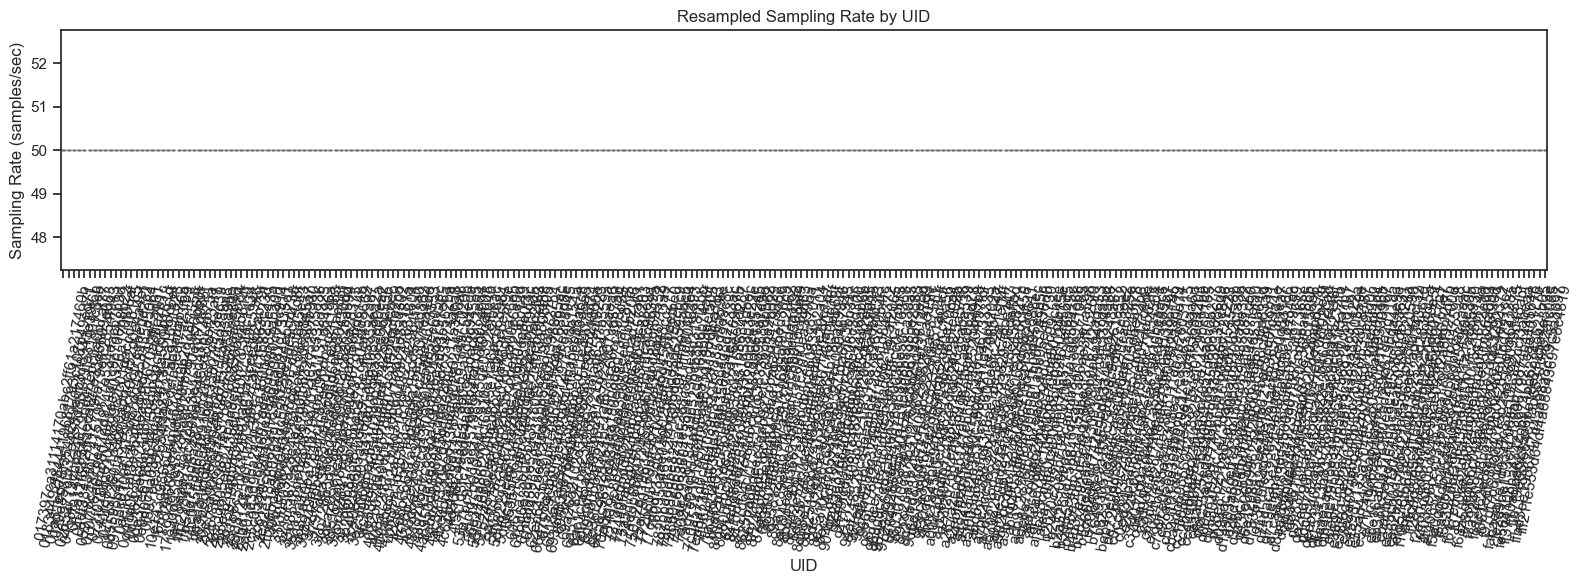

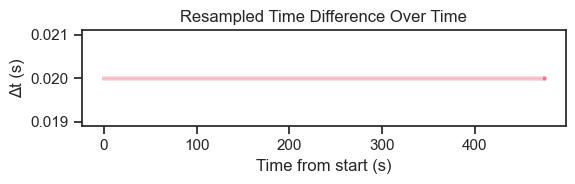

In [49]:
plot_sampling_rate_and_time_diff(resampled_df, title='Resampled')

# Applying PCA

Useful packages and functions

In [56]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  # library for progress bar
import time  # simulating elapsed time 

In [51]:
# Robust Mahalonibis Distance
def robust_mahalanobis_method_dask(df, md_name='',outlier_name='', p_md_name='', cut=0.001):
    """
    Calculate a robust version of Mahalanobis distances for each data subset,
    using the Minimum Covariance Determinant (MCD) method.
    Args:
        df (pd.DataFrame): Dataframe to calculate Mahalanobis distances for.
        md_name (str): Name of the Mahalanobis distance column.
        outlier_name (str): Name of the outlier column.
        p_md_name (str): Name of the probability of the Mahalanobis distance column.
        cut (float): Cut-off point for the Mahalanobis distance.
    Returns:
        pd.DataFrame: DataFrame with Mahalanobis distances and outlier flags
    """
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    # print(df.columns)
    # print(real_cov)
    # Check if the covariance matrix is all zeros
    if np.all(real_cov == 0):
        # Check the dimensions of real_cov
        if real_cov.ndim == 0:  # Only one variable present
        # Create a 1x1 perturbation matrix
            perturbation = np.array(1e-2)  # Increase here
        else:  # Multiple variables present
            # Add a larger perturbation to the diagonal
            perturbation = np.eye(real_cov.shape[0]) * 1e-2  # Increase here
        real_cov += perturbation
        # print(f'PERTURBATION!: {real_cov}')
    # Calculate inverse covariance
    if df.shape[1] < 2:
        # Reshape when only one column in used (e.g., 'SteeringInput')
        X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov.reshape((1,1)), 
            size= round(len(df) * 0.5)) # 50% of the data
        cov = MinCovDet(random_state=0,support_fraction=0.8).fit(X) #calculate covariance
        mcd = cov.covariance_ #robust covariance metric
        robust_mean = cov.location_  #robust mean
        inv_covmat = sp.linalg.inv(mcd) #inverse of covariance matrix
    else:
        X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size= round(len(df) * 0.5))
        cov = MinCovDet(random_state=0,support_fraction=0.8).fit(X) #calculate covariance
        mcd = cov.covariance_ #robust covariance metric
        robust_mean = cov.location_  #robust mean
        inv_covmat = sp.linalg.inv(mcd) #inverse of covariance matrix

    # Robust M-Distance
    x_minus_mu = df - robust_mean
    # Transform data into dask arrays
    x_minus_mu_dask = da.from_array(x_minus_mu.to_numpy(), chunks=(min(x_minus_mu.shape[0], 10000), df.shape[1]))
    mahal = da.sqrt(da.diagonal(da.dot(da.dot(x_minus_mu_dask,inv_covmat), x_minus_mu_dask.T)))
    # Calculate md
    md = mahal.compute()
    # Compute the chi-squared cumulative probability distribution to transfer the md2 into probabilities
    probability_md = 1 - chi2.cdf(md, df=df.shape[1])

    # Save md values and probabilities to df column
    md_df = pd.DataFrame({md_name:md,p_md_name:probability_md})
    # Set a Chi2 cut-off point using probability of 0.01 (99.5% Chi2 quantile)
    # Degrees of freedom (df) = number of variables
    threshold = chi2.ppf((1-cut), df=df.shape[1])
    # STD threshold, assuming 'md' contains your computed distances
    # mean_md = np.mean(md)
    # std_md = np.std(md)
    # threshold_3std = mean_md + 4 * std_md
    # Flag outliers as md > threshold
    md_df[outlier_name] = md_df[md_name] > threshold
    return md_df

In [52]:
# Mahalanobis distance fucntion to be used in the PCA analysis
def mahalanobis_for_pca(df):
    """
    Calculate Mahalanobis distances for each data subset.
    Args:
        df (pd.DataFrame): Input DataFrame containing the data to process
    Returns:
        pd.DataFrame: DataFrame with Mahalanobis distances and outlier flags 
        for all set of variables
    """
    ## ---- EYE columns ----
    mds_eye = robust_mahalanobis_method_dask(df=df[['eye_theta_h', 'eye_theta_v']], md_name='md_eye',
    outlier_name='eye_outlier', p_md_name='p_md_eye', cut=0.10).reset_index(drop=True)
    ## ---- HEAD columns ----
    mds_head = robust_mahalanobis_method_dask(df=df[['RelativeHeadYaw_degrees','RelativeHeadPitch_degrees',
     'RelativeHeadRoll_degrees']], md_name='md_head',outlier_name='head_outlier', p_md_name='p_md_head', cut=0.20).reset_index(drop=True)
    ## ---- CAR columns ----
    mds_car = robust_mahalanobis_method_dask(df=df[['CarYaw_degrees', 'CarPitch_degrees', 'CarRoll_degrees']],
     md_name='md_car',outlier_name='car_outlier', p_md_name='p_md_car', cut=0.10).reset_index(drop=True)
    ## ---- Steering ----
    mds_steer = robust_mahalanobis_method_dask(df=df[['streeringDegree']], md_name='md_steering',
    outlier_name='steering_outlier', p_md_name='p_md_steer', cut=0.10).reset_index(drop=True)

    ## save md and outlier data
    md_df = pd.concat([df.reset_index(drop=True),mds_eye, mds_head, mds_car,mds_steer], axis=1)
    final_df = md_df.drop(columns=['md_eye','p_md_eye','md_head','p_md_head','md_car','p_md_car',
    'md_steering','p_md_steer'])
    return final_df

# Function to interpolate NaN values in a subset of data
def interpolate_nan_pca(df):
    """
    Interpolate NaN values in a subset of data.
    Args:
        df (pd.DataFrame): Input DataFrame containing the data to process
    Returns:
        pd.DataFrame: DataFrame with interpolated NaN values
    """
    # 1. Convert 'outlier' column values to NaN where True
    # -- Eye
    df.loc[df['eye_outlier'], ['eye_theta_h', 'eye_theta_v']] = np.nan

    # -- Head
    df.loc[df['head_outlier'], ['RelativeHeadYaw_degrees', 'RelativeHeadPitch_degrees','RelativeHeadRoll_degrees']] = np.nan
    # -- Car
    df.loc[df['car_outlier'], ['CarRoll_degrees','CarYaw_degrees', 'CarPitch_degrees']] = np.nan
    # -- Steering
    df.loc[df['steering_outlier'], ['streeringDegree']] = np.nan
    # Group by 'uid' and interpolate NaN values
    interpolated_df = df.groupby('conditions').apply(lambda group: group.interpolate(method='linear').ffill().bfill()).reset_index(drop=True)
    # cleaned_df = interpolated_df.drop(columns=['eye_outlier','head_outlier','car_outlier','steering_outlier','pupil_dilation_outlier'])
    return interpolated_df

# Function to clean a subset of data by detecting and interpolating outliers during PCA analysis
def clean_subset(df):
    """
    Clean a subset of data by detecting and interpolating outliers.
    Args:
        df (pd.DataFrame): Input DataFrame containing the data to process
    Returns:
        pd.DataFrame: DataFrame with interpolated NaN values
    """
    # Detect outliers in subset by md
    subset_md = df.pipe(mahalanobis_for_pca)
    # Interpolate detected outliers
    subset_interpolated = subset_md.pipe(interpolate_nan_pca)
    return subset_interpolated


In [53]:
def init_results_dirs(base_dir: str = "results", event: str | None = None):
    """
    Initialize results directory structure with per-event subfolders.

    Structure created:
        results/
          cleaned_new/ <event_dir>
          variances/   <event_dir>
          components/  <event_dir>
          eigenvalues/ <event_dir>
          biplots/     <event_dir>
          cos_plots/   <event_dir>

    Where <event_dir> is "event_<event>" if event is provided, otherwise "all_events".

    Args:
        base_dir: Base results directory.
        event: Optional event name.

    Returns:
        dict: Mapping of category name to absolute event-specific directory path. Includes key "base".
    """
    base_abs = os.path.abspath(base_dir)
    os.makedirs(base_abs, exist_ok=True)

    event_dirname = f"event_{event}" if (event and len(str(event)) > 0) else "all_events"

    categories = [
        "cleaned_new",
        "variances",
        "components",
        "eigenvalues",
        "biplots",
        "cos_plots",
    ]

    dirs: dict[str, str] = {"base": base_abs}
    for cat in categories:
        cat_parent = os.path.join(base_abs, cat)
        os.makedirs(cat_parent, exist_ok=True)
        cat_event_dir = os.path.join(cat_parent, event_dirname)
        os.makedirs(cat_event_dir, exist_ok=True)
        dirs[cat] = cat_event_dir

    return dirs

In [54]:
# Mapping of old labels to new labels
def map_labels(labels, label_mapping):
    """
    Maps each label in the given list using the provided mapping dictionary.

    Args:
        labels (list): List of original labels.
        label_mapping (dict): Mapping dictionary for label replacement.

    Returns:
        list: New list with mapped labels.
    """
    return [label_mapping.get(label, label) for label in labels]

# Define your label mapping (you can modify this as needed)
custom_mapping = {
    'eye_theta_h': 'Eye Horizontal',
    'eye_theta_v': 'Eye Vertical',
    'RelativeHeadYaw_degrees': 'Head Yaw',
    'RelativeHeadPitch_degrees': 'Head Pitch',
    'RelativeHeadRoll_degrees': 'Head Roll',
    'CarYaw_degrees': 'Car Yaw',
    'streeringDegree': 'Steering',
    'conditions': 'Condition',
}

# Function to plot a biplot of PCA scores and loadings
def biplot(score, coef, eigenvalues,
           labels=None,
           colors=None,
           explained_variance=None,
           vector_colors=None,
           scaled=None,
           vector_linewidth=None):
    """
    Plot a biplot of PCA scores and loadings.
    Args:
        score (np.ndarray): PCA scores.
        coef (np.ndarray): PCA loadings.
        eigenvalues (np.ndarray): Eigenvalues.
        labels (list): List of original labels.
        colors (list): List of colors for each label.
        explained_variance (list): List of explained variances.
        vector_colors (list): List of colors for each vector.
        scaled (bool): Whether to scale the vectors.
        vector_linewidth (float): Linewidth for the vectors.

    Returns:
        None: Plots the biplot.

    Raises:
        TypeError: If the input is not a PCA object.
    """
    plt.rcParams.update({'font.size': 20})
    # Apply 90-degree rotation matrix to `score` and `coef`
    # rotation_matrix = np.array([[0, -1], [1, 0]])
    # Rotate the first two components of the scores
    # score = np.dot(score[:, :2], rotation_matrix)
    # Rotate the first two components of the loadings
    # coef = np.dot(coef[:, :2], rotation_matrix)
    xs = score[:, 0]
    ys = score[:, 1]
    n = coef.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())

    padding= 1.2 # 20% padding for axis and vector scaling
    padding_text = 1.1 # 10 % padding for text
    xlims = padding * np.max(np.abs(xs))
    ylims = padding * np.max(np.abs(ys))
    if colors is None:  # If no color information, plot all points orange
        plt.scatter(xs, ys, s=80, color='gray', alpha=0.5,edgecolor='gray')
        # plt.scatter(xs, ys, s=80, color='orange')
    else:  # If color information is given, plot points with corresponding colors
        # plt.scatter(xs * scalex, ys * scaley, s=80, color=colors, alpha=0.5)
        plt.scatter(xs, ys, s=80, color=colors, alpha=0.5,edgecolor=colors)
    plt.xlim(-xlims * padding,xlims * padding)
    plt.ylim(-ylims* padding,ylims* padding)

    # Adjust the number of labels to match the number of coefficients
    original_labels = labels[:n]

    # Call the function to get the new mapped labels
    labels = map_labels(original_labels, custom_mapping)

    # Draw principal component vectors as arrows
    for i in range(n):
        # Calculate arrow end point (arrow head)
        arrow_end_x = xlims * coef[i, 0]
        arrow_end_y = ylims * coef[i, 1]
        if scaled:
            # Draw the arrow starting from the origin (0, 0) to the arrow head
            plt.arrow(0, 0, arrow_end_x, arrow_end_y, color=vector_colors[i], alpha=1, linewidth=vector_linewidth,length_includes_head=True,head_length=0.1,head_width=0.1,overhang=0)
        else:
            plt.arrow(0, 0, arrow_end_x, arrow_end_y, color=vector_colors[i], alpha=1, linewidth=vector_linewidth,length_includes_head=True,head_length=0.7,head_width=0.7,overhang=0)
    # Position the label above the arrow head
        if labels is not None:
            if arrow_end_y > 0:
                va='bottom'
            else:
                va='top'
            # Annotate the point with text (you can customize the text as needed)
            plt.text(arrow_end_x * padding_text, arrow_end_y * padding_text,
                     f"{labels[i]}\n({coef[i, 0]:.2f}, {coef[i, 1]:.2f})",color='black',ha='center', va=va,fontdict=dict(fontsize=14), bbox=dict(facecolor='white', alpha=0.0001, edgecolor='white'))
    # Write first two eigenvalues
    # plt.text(-ylims + padding_text, -xlims * padding_text, "Eigenvalues:\n {:.2f}, {:.2f}".format(*eigenvalues),ha='left', va='bottom', fontsize=10)
    # Write all eigenvalues
    # plt.text(-ylims + 0.5, -xlims + 0.5, "Eigenvalues:\n " + ", ".join(f"{val:.2f}" for val in eigenvalues), ha='left', va='bottom', fontsize=10)

    # Set fixed axis limits
    ax = plt.gca()
    fixed_x_min, fixed_x_max = -xlims, xlims  # Your specified x limits
    fixed_y_min, fixed_y_max = -ylims, ylims  # Your specified y limits

    # Set the fixed limits
    plt.xlim(fixed_x_min, fixed_x_max)
    plt.ylim(fixed_y_min, fixed_y_max)

    # Hide all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Parameters for arrows
    arrow_length = 0.15  # Size of the arrowhead
    arrow_linewidth = 2.5

    # Create y-axis arrow (vertical) ON THE LEFT SPINE
    #  Start at bottom left corner
    ax.arrow(fixed_x_min +arrow_length, fixed_y_min+arrow_length,
             0, fixed_y_max - (fixed_y_max/2.5),  # Go up to max - arrowhead space
             head_width=arrow_length, head_length=arrow_length,
             fc='black', ec='black', linewidth=arrow_linewidth,
             length_includes_head=True)

    # Create x-axis arrow (horizontal) ON THE BOTTOM SPINE
    # Start at bottom left corner
    ax.arrow(fixed_x_min +arrow_length, fixed_y_min+arrow_length,
             fixed_x_max - (fixed_x_max/2.5), 0,  # Go right to max - arrowhead space
             head_width=arrow_length, head_length=arrow_length,
             fc='black', ec='black', linewidth=arrow_linewidth,
             length_includes_head=True)
    # Hide tick parameters
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove standard labels
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Add custom positioned labels
    # X-axis label - at the start of the x-axis arrow
    ax.text(fixed_x_min + 1.5, fixed_y_min - 0.1,  # Position just below the arrow end
            "PC{} ({:.1f}%)".format(1, explained_variance[0] * 100),
            fontsize=18, ha='right', va='top')

    # Y-axis label - at the start of the y-axis arrow
    ax.text(fixed_x_min + 0.02, fixed_y_min + 0.6,  # Position to the left of arrow end
            "PC{} ({:.1f}%)".format(2, explained_variance[1] * 100),
            fontsize=18, ha='right', va='bottom', rotation=90)

    # Add a legend for the colors if provided
    if colors is not None:
        legend_elements = [
            Line2D([0], [0],
                   marker='o',
                   color='w',
                   markerfacecolor='#2A586E',
                   markersize=12,
                   label='Manual',
                   alpha=0.8),
            Line2D([0], [0],
                   marker='o',
                   color='w',
                   markerfacecolor='#cc2936',
                   markersize=12,
                   label='Autonomous',
                   alpha=0.8)
        ]
        plt.legend(handles=legend_elements, fontsize=16)

def get_pca_var(pca, subset_scaled, feature_names):
    # Validate input types
    if not isinstance(pca, PCA):
        raise TypeError("Expected a PCA object from sklearn.decomposition.PCA")

    # Compute coordinates
    coords = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Compute correlations
    # Since we're using standardized data:
    cor = coords / np.std(subset_scaled, axis=0)

    # Compute cos2 (squared loadings or cosine similarity)
    cos2 = np.square(cor)

    # Compute contributions
    total_variance = np.sum(pca.explained_variance_)
    contrib = (cos2 * 100 * pca.explained_variance_) / total_variance

    # Create dataframes with feature names as the index
    coord_df = pd.DataFrame(coords, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    cor_df = pd.DataFrame(cor, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    cos2_df = pd.DataFrame(cos2, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    contrib_df = pd.DataFrame(contrib, index=feature_names, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    return {
        'coord': coord_df,
        'cor': cor_df,
        'cos2': cos2_df,
        'contrib': contrib_df
    }

from matplotlib.patches import Circle
from matplotlib import colors as mcolors

def plot_cosine_similarity(cos2_df, title='', event='', time_point='', save=False, output_dir: str | None = None, image_format: str = 'pdf'):
    """
    Plot the cosine similarity of the PCA components.
    Args:
        cos2_df (pd.DataFrame): DataFrame containing cosine similarity values.
        title (str): Title of the plot.
        event (str): Event name.
        time_point (str): Time point.
        save (bool): Whether to save the plot.

    Returns:
        None: Plots the cosine similarity plot.
    """
    # Extract feature names directly from the DataFrame index
    feature_names = cos2_df.index

    # max_cos2_value = max(cos2_df['PC1'])  # color bar maximum limit
    max_cos2_value = 1  # color bar maximum limit
    # Create a custom colormap from white to #A2530E
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "#A2530E"])

    features, components = cos2_df.shape
    fig, ax = plt.subplots(figsize=(10, 8))
    if len(feature_names) > 10:
        num_fontsize = 10
    num_fontsize = 12
    ax.set_title(title, fontsize=18)

    # Plot each circle and add annotations
    for i in range(features):
        for j in range(components):
            value = cos2_df.iloc[i, j]
            color = cmap(value / max_cos2_value)  # Normalize the color
            circle = Circle((j, i), radius=np.sqrt(value) * 0.5, color=color, fill=True)
            ax.add_artist(circle)

            # Annotate the cos2 value at the center of the circle
            ax.text(
                j, i, f'{value:.2f}',
                color='lightgray',
                ha='center', va='center',
                fontsize=num_fontsize,  # Adjust font size for readability
            )

    # Setup axis limits and labels
    ax.set_xlim(-0.5, components - 0.5)
    ax.set_ylim(-0.5, features - 0.5)
    ax.set_xticks(np.arange(components))
    ax.set_yticks(np.arange(features))
    ax.set_xticklabels([f'PC{i+1}' for i in range(components)], rotation=0)
    ax.set_yticklabels(feature_names)
    ax.set_aspect('equal', 'box')

    # Add grid lines for clarity
    ax.hlines(np.arange(-0.5, features), xmin=-0.5, xmax=components - 0.5, color='grey', lw=0.5)
    ax.vlines(np.arange(-0.5, components), ymin=-0.5, ymax=features - 0.5, color='grey', lw=0.5)

    # Set outer border to gray by modifying the spines
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')
        spine.set_linewidth(0.5)

    # Add a color bar on the right
    norm = mcolors.Normalize(vmin=0, vmax=max_cos2_value)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, label='$Cos^2$')

    # Increase the number of ticks on the color bar for better granularity
    num_ticks = 6
    cbar.set_ticks(np.linspace(0, max_cos2_value, num_ticks))
    cbar.set_ticklabels([round(val, 2) for val in np.linspace(0, max_cos2_value, num_ticks)])
    cbar.outline.set_visible(True)
    plt.tight_layout()
    if save:
        if output_dir is None:
            # Fallback: ensure a safe directory exists under results/cos_plots/<event>
            _dirs = init_results_dirs(event=event if event else None)
            output_dir = _dirs['cos_plots']
        filename = f"pca_cos2_{event or 'all_events'}_{time_point}_{''.join(map(str, feature_names))}.{image_format}"
        plt.savefig(os.path.join(output_dir, filename), dpi=1200)
    plt.show()

# Calculate and visualize PCA

In [55]:
# Map each condition to a float number
label_mapping = {'Manual': 1, 'Autonomous': 0}
# with outliers
resampled_df.loc[:,'conditions'] = resampled_df['Condition'].map(label_mapping)

In [ ]:
# Directories to save results
# from tqdm import tqdm  # Import the tqdm library for progress bar
# import time  # Import time for simulating or handling elapsed time calculation

# Define the base results path
# results_path = "pca_results"

# # Create base results directory
# os.makedirs(results_path, exist_ok=True)

# # Create subdirectories under the base results path
# directories = {
#     "cleaned_new": os.path.join(results_path, "cleaned_new"),
#     "variances": os.path.join(results_path, "variances"),
#     "components": os.path.join(results_path, "components"),
#     "eigenvalues": os.path.join(results_path, "eigenvalues")
# }

# # Create each subdirectory
# for subdir in directories.values():
#     os.makedirs(subdir, exist_ok=True)

In [57]:
# Calculate PCA
def visualize_event_pca(df, event='', time_point='', features='', scaled=True, vis_biplot=True, save_biplot=False, save_cos2_plot=False, save_cleaned=False, direc_path='', interactive=True):
    if event != '':
        event_df = df[df['Event'] == event]
        timestamps = event_df['time'].unique()
    else:
        timestamps = df['time'].unique()
    # DataFrames to save data
    df_cleaned_ts = pd.DataFrame()
    df_event_components = pd.DataFrame()
    df_event_variance = pd.DataFrame()
    df_pca_results = pd.DataFrame()
    df_sorted_eigenvalues = pd.DataFrame()  # To store sorted eigenvalues

    # Cache for interactive viewing
    cache = {}
    # Prepare directories if saving any artifacts
    if save_biplot or save_cos2_plot or save_cleaned:
        _dirs = init_results_dirs(event=event if event else None)

    # Updated: Progress bar using tqdm
    with tqdm(total=len(timestamps), desc="Processing times", unit="", colour="green") as pbar:
        start_time = time.time()  # Store the starting time
        for i, timestamp in enumerate(timestamps):
            # 0. Extract rows for this timestamp
            subset = df[df['time'] == timestamp]
            event_name = subset['Event'].unique()[0]

            # 1. Update progress bar for the current timestamp
            pbar.set_postfix_str(f"Current Timestamp: {timestamp}")

            # 2. Clean outliers in subset
            subset_cleaned = subset.pipe(clean_subset)

            # 3. Features
            subset_features1 = subset_cleaned[subset_cleaned.columns.intersection(features)]
            subset_features_renamed = subset_features1.rename(columns=custom_mapping)
            subset_features = subset_features_renamed.drop(columns=['Condition'])
            original_labels = list(subset_features.columns)

            # 3.1 Colors
            colors = [
                '#71898E' if condition == 1 else '#cc2936'  # Manual
                for condition in subset_features_renamed['Condition']
            ]

            # 4. Scaling
            if scaled:
                scaler = StandardScaler(with_std=True)
                subset_scaled = scaler.fit_transform(subset_features)
            else:
                subset_scaled = subset_features

            # 5. Perform PCA
            pca = PCA(whiten=True, svd_solver='full')
            pca_result = pca.fit_transform(subset_scaled)
            explained_variance = pca.explained_variance_ratio_
            eigenvalues = pca.explained_variance_

            # 5.1 Sorted eigenvalues
            sorted_eigenvalue_columns = [f'eigen_val{i+1}' for i in range(len(eigenvalues))]
            eigenvalues_df = pd.DataFrame([eigenvalues], columns=sorted_eigenvalue_columns)
            eigenvalues_df['Time'] = timestamp
            eigenvalues_df['Event'] = event_name
            df_sorted_eigenvalues = pd.concat([df_sorted_eigenvalues, eigenvalues_df], ignore_index=True)

            # Save PCA results
            pca_result_df = pd.DataFrame(
                pca_result,
                columns=[f'PC{i+1}' for i in range(len(explained_variance))]
            )
            pca_result_df['Time'] = timestamp
            pca_result_df['Event'] = event_name
            df_pca_results = pd.concat([df_pca_results, pca_result_df], ignore_index=True)

            # Components
            loadings = pd.DataFrame(
                pca.components_.T,
                columns=[f'PC{i+1}' for i, v in enumerate(explained_variance)],
            )
            loadings['Features'] = original_labels
            loadings['Time'] = timestamp
            loadings['Event'] = event_name
            df_event_components = pd.concat([df_event_components, loadings], ignore_index=True)

            # Variance
            df_variances = pd.DataFrame(
                np.reshape(explained_variance, (1, len(explained_variance))),
                columns=[f'PC{i+1}' for i, v in enumerate(explained_variance)]
            )
            df_variances['Time'] = timestamp
            df_variances['Event'] = event_name
            df_event_variance = pd.concat([df_event_variance, df_variances], ignore_index=True)

            # Save plots immediately if requested (slider is for viewing only)
            if save_biplot:
                biplot_dir = _dirs['biplots']
                sns.set_theme(style="white")
                plt.figure(figsize=(14, 10))
                plt.title('Second: ' + str(timestamp), fontsize=22)
                biplot(
                    pca_result,
                    pca.components_.T,
                    eigenvalues,
                    original_labels,
                    colors,
                    explained_variance,
                    vector_colors=['k'] * len(original_labels),
                    scaled=scaled,
                    vector_linewidth=1.1
                )
                filename = f"pca_{event or 'all_events'}_{time_point}_{''.join(map(str, original_labels))}.pdf"
                plt.savefig(os.path.join(biplot_dir, filename), dpi=1200)
                plt.close()

            if save_cos2_plot:
                pca_cos2 = get_pca_var(pca, subset_scaled, original_labels)
                cos2_matrix = pca_cos2['cos2']
                plot_cosine_similarity(cos2_matrix, title='Cosine Similarity ($Cos^2$)', save=True, event=event, time_point=time_point, output_dir=_dirs['cos_plots'])
                plt.close()

            # Visualization for non-interactive mode only
            if vis_biplot and not interactive:
                sns.set_theme(style="white")
                plt.figure(figsize=(14, 10))
                plt.title('Second: ' + str(timestamp), fontsize=22)
                biplot(
                    pca_result,
                    pca.components_.T,
                    eigenvalues,
                    original_labels,
                    colors,
                    explained_variance,
                    vector_colors=['k'] * len(original_labels),
                    scaled=scaled,
                    vector_linewidth=1.1
                )
                plt.show()

                pca_cos2 = get_pca_var(pca, subset_scaled, original_labels)
                cos2_matrix = pca_cos2['cos2']
                plot_cosine_similarity(cos2_matrix, title='Cosine Similarity ($Cos^2$)', save=False, event=event, time_point=time_point)

            # Cleaned subset
            if save_cleaned:
                subset_features_renamed['Event'] = event_name
                subset_features_renamed['Time'] = timestamp
                df_cleaned_ts = pd.concat([df_cleaned_ts, subset_features_renamed], ignore_index=True)

            # Store in cache for interactive viewing
            cache[i] = {
                'timestamp': timestamp,
                'original_labels': original_labels,
                'colors': colors,
                'pca': pca,
                'pca_result': pca_result,
                'explained_variance': explained_variance,
                'eigenvalues': eigenvalues,
                'subset_scaled': subset_scaled,
            }

            # Update progress bar and elapsed time
            elapsed_time = time.time() - start_time
            pbar.update(1)
            pbar.set_postfix_str(f"Elapsed: {elapsed_time:.2f}s")

    # Save results
    if save_cleaned:
        if len(timestamps) > 1:
            timestamp = 'all'
        # Ensure event-specific data directories exist
        data_dirs = init_results_dirs(event=event if event else None)
        df_cleaned_ts.to_csv(os.path.join(data_dirs['cleaned_new'], f"cleaned_event_{event or 'all_events'}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv"), index=False)
        df_event_variance.to_csv(os.path.join(data_dirs['variances'], f"variances_event_{event or 'all_events'}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv"), index=False)
        df_event_components.to_csv(os.path.join(data_dirs['components'], f"components_event_{event or 'all_events'}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv"), index=False)
        df_sorted_eigenvalues.to_csv(os.path.join(data_dirs['eigenvalues'], f"eigenval_event_{event or 'all_events'}_timestamp_{str(timestamp)}_{len(original_labels)}_variables.csv"), index=False)

    # Interactive slider viewer (plots stacked) - viewing only, no saving here
    if interactive and vis_biplot and len(timestamps) > 0:
        import ipywidgets as widgets
        from IPython.display import display

        slider = widgets.IntSlider(
            min=0,
            max=len(timestamps)-1,
            step=1,
            value=0,
            description='Time Point',
            layout=widgets.Layout(width='800px'),
            continuous_update=True,
        )

        def render(idx: int):
            comp = cache.get(idx)
            if comp is None:
                return
            sns.set_theme(style="white")
            plt.figure(figsize=(14, 10))
            plt.title('Second: ' + str(comp['timestamp']), fontsize=22)
            biplot(
                comp['pca_result'],
                comp['pca'].components_.T,
                comp['eigenvalues'],
                comp['original_labels'],
                comp['colors'],
                comp['explained_variance'],
                vector_colors=['k'] * len(comp['original_labels']),
                scaled=scaled,
                vector_linewidth=1.1
            )
            plt.show()

            pca_cos2 = get_pca_var(comp['pca'], comp['subset_scaled'], comp['original_labels'])
            cos2_matrix = pca_cos2['cos2']
            plot_cosine_similarity(cos2_matrix, title='Cosine Similarity ($Cos^2$)', save=False, event=event, time_point=time_point)

        out = widgets.interactive_output(render, {'idx': slider})
        display(slider, out)

    return df_event_components, df_event_variance, original_labels, df_cleaned_ts, df_pca_results, df_sorted_eigenvalues


## Variables for PCA

In [58]:
# Define the columns of the df to use in PCA
conditions = ['conditions']
euler_features = ['eye_theta_h', 'eye_theta_v',
                  'RelativeHeadYaw_degrees',
                  'RelativeHeadPitch_degrees',
                  'RelativeHeadRoll_degrees',
                  'CarYaw_degrees','streeringDegree']

In [59]:
event = 'one'
scaled = True
features = conditions + euler_features

components_df, variances_df, original_labels, df_cleaned_ts,df_pca_results, eigenvalues_df = visualize_event_pca(resampled_df, event=event, 
features=features, scaled=scaled, vis_biplot=True, save_biplot=False, save_cos2_plot=False, save_cleaned=False)

Processing times: 100%|██████████| 508/508 [01:11<00:00,  7.09/s, Elapsed: 71.61s]         


IntSlider(value=0, description='Time Point', layout=Layout(width='800px'), max=507)

Output()

In [3]:
import sys, ipywidgets as w, IPython
print(sys.executable); print(IPython.__version__); print(w.__version__)

/Users/johnmadrid/dev/phd_main/bin/python
9.4.0
8.1.7


In [1]:
from IPython.display import display
import ipywidgets as widgets

widgets.IntSlider()

IntSlider(value=0)

## Visualize PCA and Cosine Similarity

In [47]:
resampled_df['uid'].nunique()

284

In [48]:
event = 'one'
# time_point=''
scaled = True
features = conditions + euler_features
interactive=True 
vis_biplot=True,
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
timestamps = sorted(resampled_df[resampled_df['Event'] == event]['time'].unique())
# inside visualize_event_pca, before creating the slider
# if interactive and vis_biplot:
#     try:
#         import ipywidgets as widgets
#         from IPython.display import display, clear_output
#     except ImportError:
#         raise ImportError("Please install ipywidgets (pip install ipywidgets)")
# %config InlineBackend.figure_format = 'svg'

interactive_event_pca(
    resampled_df,
    event=event,
    features=features,
    scaled=True,
    save_biplot=False,     # True => pre-saves all biplots before showing the UI
    save_cos2_plot=False,  # True => pre-saves all Cos² plots before showing the UI
    time_point=''          # kept only for filename consistency
)

TypeError: interactive_event_pca() got an unexpected keyword argument 'time_point'

In [ ]:
event = 'one'
time_point='high_var_euler'
scaled = True
features = conditions + euler_features #+ features_derivatives
# features = conditions + euler_features # + combined_derivatives

components_df, variances_df, original_labels, df_cleaned_ts,df_pca_results, eigenvalues_df = visualize_event_pca(resampled_df, event=event, time_point=time_point, 
features=features, scaled=scaled, vis_biplot=True, save_biplot=False, save_cos2_plot=False, save_cleaned=False)#, direc_path=directories)


import ipywidgets as widgets  # Add import if not already present
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'svg'
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

event = 'one'
time_point = 'dynamic'
scaled = True
timestamps = sorted(resampled_df[resampled_df['Event'] == event]['time'].unique())
@widgets.interact(d_ts=widgets.FloatSlider(value=0.2, min=-5, max=5, step=0.02,description='Time',layout=widgets.Layout(width='800px')))

def interactive_pca(d_ts):
    components_df, variances_df, original_labels, df_cleaned_ts, df_pca_results, eigenvalues_df = visualize_event_pca(
        resampled_df,
        event=event,
        time_point=time_point,
        d_ts=d_ts, # dynamic timestamp for slider
        features=features,
        scaled=scaled,
        vis_biplot=True,
        output_mode='show',
        legend_mode='condition',
        save_biplot=True,
        save_cos2_plot=True,
        save_cleaned=True,
        direc_path=directories
    )

Processing times: 100%|██████████| 508/508 [01:05<00:00,  7.77/s, Elapsed: 65.36s]         


NameError: name 'widgets' is not defined

In [ ]:
components_df, variances_df, original_labels, df_cleaned_ts, df_pca_results, eigenvalues_df = visualize_event_pca(
    resampled_df,
    event='one',
    features= conditions + euler_features,
    scaled=True,
    vis_biplot=True,
    save_biplot=False,      # set True to pre-save all biplots
    save_cos2_plot=False,   # set True to pre-save all Cos² plots
    save_cleaned=False,     # set True to save cleaned CSV
    interactive=True        # slider enabled
)

Processing times: 100%|██████████| 508/508 [01:04<00:00,  7.92/s, Elapsed: 64.11s]         


NameError: name 'widgets' is not defined

In [ ]:
# event = 'one'
# time_point='high_var_euler'
# scaled = True
# features = conditions + euler_features #+ features_derivatives
# # features = conditions + euler_features # + combined_derivatives

# components_df, variances_df, original_labels, df_cleaned_ts,df_pca_results, eigenvalues_df = visualize_event_pca(resampled_df, event=event, time_point=time_point, features=features, scaled=scaled, vis_biplot=True, save_biplot=False, save_cos2_plot=False, save_cleaned=False)#, direc_path=directories)

## Visualize variance

In [ ]:
# List file names in the 'variances' folder
variances_path = directories['variances']
variances_files = os.listdir(variances_path)

# Print the file names
print("Files in 'variances' folder:", variances_files)

In [ ]:
# Load variance df
variances_df = dd.read_csv(f"{directories['variances']}/variances_event__all_events__timestamp_all_7_variables.csv").compute()
variances_df

## useful Functions

In [ ]:
# Smoothing variances
def smooth_variances(df):
    # Create 'Event' column only if it does not exist in the DataFrame
    if 'Event' not in df.columns:
        df['Event'] = 'one'

    # df.loc[:,'PC1-2'] = df['PC1'] + df['PC2']
    # Calculate rolling mean for each column
    var_smooth_df = df.drop(columns=['Time','Event']).apply(lambda col: col.rolling(window=50, min_periods=5, center=True).mean())
    # print(var_smooth_df.columns)
    # Make time a column in the df
    var_smooth_df.loc[:,'Time'] = df['Time']
    var_smooth_df.loc[:,'Event'] = df['Event']
    var_smooth_df.reset_index(drop=True, inplace=True)
    # Melt df to make it long
    var_smooth_df = var_smooth_df.melt(id_vars=['Time','Event'],
                              var_name='PCs',
                              value_name='pca_value')
    return var_smooth_df, df

def segment_event(df, event=''):
    # identify PCs largest variances
    largest_variances = df[~df['Event'].str.contains('none|BE|AF')].groupby('Event')['PC1'].idxmax()
    max_variances_df = df[['PC1', 'Time', 'Event']].loc[largest_variances]

    # identify the max PC1 timestamp for the given event
    pc1_max_ts = max_variances_df[max_variances_df['Event'] == event]['Time']

    # subset df for the chosen event
    event_df = df[df['Event'] == event]

    # Ensure the event_df is not empty
    if event_df.empty:
        raise ValueError(f"The event '{event}' does not exist in the DataFrame.")

    # Ensure the 'Time' column exists and compute the min and max values
    if 'Time' not in event_df.columns:
        raise KeyError("'Time' column is missing in the provided DataFrame.")

    # Identify min and max timestamps
    start_time = min(event_df['Time'])
    end_time = max(event_df['Time'])


    # start and end window
    start_window = 1.5
    end_window = 2

    # event segment including left and right window
    event_segment_df = df.loc[(df['Time'] >= (start_time - start_window)) & (df['Time'] <= (end_time + end_window))].copy()

    # safely add PC1-2 variances using .loc
    event_segment_df.loc[:, 'PC1-2'] = event_segment_df['PC1'] + event_segment_df['PC2']

    # 2 seconds search window
    s_window = 2

    # segment around max PC1
    segment_around_maxpc1 = event_segment_df.loc[
        (event_segment_df['Time'] >= (float(pc1_max_ts) - s_window)) &
        (event_segment_df['Time'] <= (float(pc1_max_ts) + s_window))
    ]

    # using segmented df to identify maximum combined variance
    max_combined_var = segment_around_maxpc1[
        segment_around_maxpc1['PC1-2'] == segment_around_maxpc1['PC1-2'].max()
    ][['Time', 'Event', 'PC1-2']]

    # using event df to identify minimum combined variance within the event
    event_seg_df = event_segment_df[event_segment_df['Event'] == event]
    min_combined_var = event_seg_df[
        event_seg_df['PC1-2'] == event_seg_df['PC1-2'].min()
    ][['Time', 'Event', 'PC1-2']]

    return event_segment_df, min_combined_var, max_combined_var

# Visualize variance over time
def visualize_variance(df, event='', save=False, title='', save_name=''):
    sns.set(style="ticks")  # Set the style to include ticks
    if event != '':
        event = event
        tick_interval = 2
        figsize= (8,6)
        fontsize = 12
        onset_font_size = 10
        onset_pos = 0.1
        df, min_first_2_pcs, max_first_2_pcs = segment_event(df,event=event)
    else:
        event='all_events'
        tick_interval = 50
        figsize = (24,10)
        fontsize = 24
        onset_font_size = 16
        onset_pos = 2
    fig, ax = plt.subplots(1,1,figsize=figsize)
    # Smooth variance
    var_smooth_df, var_df = smooth_variances(df)

    # Calculate joined variance
    for column in var_df.columns:
        if column != 'Event' and column != 'PC1-2' and column != 'Time':
            plt.plot(var_df['Time'], var_df[column], c='gray', linestyle='--', alpha=0.4, linewidth=1)
    # Visualize smoothed variance without pc1-2
    smooth_df = var_smooth_df[~var_smooth_df['PCs'].isin(['PC1-2'])]
    sns.lineplot(x='Time', y='pca_value', data=smooth_df, hue='PCs', linewidth=2.5, linestyle='-', palette=color_pca)

    # Get the unique events
    events = smooth_df[~smooth_df['Event'].str.contains('NoEv|BE|AF')]['Event'].unique()

    for i, event in enumerate(events):
        # save_name = event
        if len(events) <=1:
            if len(var_df.columns) > 11:
                max_ts = 25.22
            else:
                max_ts = max_first_2_pcs['Time'].iloc[0]
            min_ts = min_first_2_pcs['Time'].iloc[0]
            print(f"Max variance: {max_ts}; Min variance: {min_ts}")
            plt.axvline(x=max_ts, color='#7f7f7f', linestyle='--', linewidth=2)
            plt.axvline(x=min_ts, color='#7f7f7f', linestyle='--', linewidth=2)

        # Filter the dataframe for the current event
        event_df = smooth_df[smooth_df['Event'] == event]

        # Get the start and end time of the event
        start_time = event_df['Time'].min()
        end_time = event_df['Time'].max()

        # Plot vertical lines at the start and end of the event
        plt.axvline(x=start_time, color='#7f7f7f', linestyle='--', linewidth=2.5)
        plt.axvline(x=end_time, color='#7f7f7f', linestyle='--', linewidth=2.5)

        plt.text(start_time - onset_pos, np.mean(event_df['pca_value']) - 0.02, f'event {event} onset'.title(), rotation=90, fontsize=onset_font_size, color='#7f7f7f', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round', alpha=0.9))
        plt.text(end_time, np.mean(event_df['pca_value']) - 0.02, f'Event {event} Offset'.title(), rotation=90, fontsize=onset_font_size, color='#7f7f7f', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round', alpha=0.9))

        # Shade the area inside the event segment
        plt.fill_betweenx([min(smooth_df['pca_value']), max(smooth_df['pca_value'])], start_time, end_time, color='#EEE59F', alpha=0.2)

    # Change axes parameters
    x_min = min(smooth_df['Time'])
    x_max = max(smooth_df['Time'])
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, max(smooth_df['pca_value'] + 0.01))
    # Increased the legend title font size here
    plt.legend(title='Components', fontsize=fontsize, title_fontsize=fontsize)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), fontsize=fontsize-3)

    sns.despine(offset=1, trim=False)
    # Find the nearest even number for x_min
    if x_min % 2 != 0:  # If not even
        x_min = round(x_min+0.3) # Round up to the nearest even number

    ax.set_xticks(np.arange(x_min, x_max, tick_interval))
    # change the fontsize
    ax.tick_params(axis='x', labelsize=onset_font_size)
    ax.tick_params(axis='y', labelsize=onset_font_size)
    # ax.tick_params(labelsize=fontsize-4)  # Reduced font size for tick labels
    plt.xlabel('Time (s)', fontsize=fontsize+2)
    plt.ylabel('Explained Variance', fontsize=fontsize+2)
    plt.title(title, fontsize=fontsize, y=1.05)
    plt.tight_layout()
    pc_lables = var_smooth_df['PCs'].unique()

    if save:
        plt.savefig(f"plots/pca_new/timeplots/{save_name}_event_{event}_{''.join(map(str, pc_lables))}_variance" + '.jpeg', dpi=1000)

Visualize variance for entire recording duration

In [ ]:
color_pca = {
    'PC1': '#F72B2B', 'PC2': '#B10606',
    'PC3': '#962222', 'PC4': '#851E1E',
    'PC5': '#641717', 'PC6': '#430F0F',
    'PC7': '#3A0E0E',
}

# visualize PCs variance over time
visualize_variance(var_df,event='', save=True, title = 'Course of event dynamics on Eye-Head-Car-Steering',save_name='timeplot')

Visualize variance for one event

In [ ]:
# visualize PCs variance over time
visualize_variance(var_df,event='one', save=True, title = 'Course of event dynamics on Eye-Head-Car-Steering',save_name='timeplot_variances_event_one')

# Effective Dimensionality (ED)

In [ ]:
# List file names in the 'variances' folder
eig_path = directories['eigenvalues']
eig_files = os.listdir(eig_path)

# Print the file names
print("Files in 'eigenvalues' folder:", eig_files)

In [ ]:
# Load eigenvalues df
eigenvalues_df = dd.read_csv(f"{eig_path}/{eig_files[0]}").compute()
eigenvalues_df

Functions to compute ED

In [ ]:
def compute_ED_estimators(eigenvalues):
    """
    Compute Effective Dimensionality estimators from eigenvalues.
    This function follows Del Giudice (2021) implementation in R language
    Parameters:
    eigenvalues (list or array): List of eigenvalues.
    Returns:
    dict: Dictionary containing various ED estimators (n1, n2, nInf, nC).
    """
    output = {}

    # Make eigenvalues a numpy array for easier manipulation
    eigen_val = np.array(eigenvalues)

    # Compute ED estimators
    K = len(eigen_val)
    eigen_sum = np.sum(eigen_val)
    norm_eigen_val = eigen_val / eigen_sum

    # Calculate variance using the K/(K-1) adjustment
    eigen_var = np.var(eigen_val, ddof=0) * ((K - 1) / K)

    # Calculate the four different estimators
    output["n1"] = np.prod(norm_eigen_val ** (-norm_eigen_val))
    output["n2"] = (eigen_sum ** 2) / np.sum(eigen_val ** 2)
    output["nInf"] = eigen_sum / np.max(eigen_val)
    output["nC"] = K - ((K ** 2) / (eigen_sum ** 2)) * eigen_var

    return output

# Process eigenvalues_df DataFrame
def calculate_ED(df):
    """
    Process eigenvalues from a DataFrame to compute ED estimators per timestamp.
    Parameters:
    df (DataFrame): A DataFrame containing eigenvalues and a Time column.
    Returns:
    DataFrame: A new DataFrame containing ED estimators and the Time column.
    """
    results = []

    for _, row in df.iterrows():
        # Exclude Time, Event col and handle NaNs (if any)
        eigenvalues = row[:-2].dropna()
        time = row['Time']
        event = row['Event']
        ed_estimators = compute_ED_estimators(eigenvalues)
        ed_estimators['Time'] = time
        ed_estimators['Event'] = event
        results.append(ed_estimators)

    # Convert results to a DataFrame
    processed_df = pd.DataFrame(results)
    return processed_df

# Apply function to eigenvalues_df
# ed_df = calculate_ED(eigenvalues_df)

# Display the resulting DataFrame
# ed_df

Functions to visualize ED

In [ ]:
def create_combined_visualization(eigenvalues_df, ed_df, features=None,
                                  cmap="viridis", save=False, save_name='ED_and_eigval_magnitudes'):
    """
    Creates a two-row subplot with effective dimensionality visualization on top
    and eigenvalues heatmap on the bottom, using `constrained_layout` for better spacing.

    Parameters:
    -----------
    eigenvalues_df : pandas.DataFrame
        DataFrame containing eigenvalues with 'Time' as one column and eigenvalue columns.
    ed_df : pandas.DataFrame
        DataFrame containing ED estimates with columns ['Time', 'n1', 'n2', 'nInf', 'nC'].
    features : list, optional
        List of features used in the analysis (for title display).
    cmap : str, optional
        Colormap to use for the heatmap, default is "viridis".
    save : bool, optional
        Whether to save the plot as a file, default is False.

    Returns:
    --------
    None
    """

    # Find the earliest and latest timestamps across both dataframes
    time_min = min(ed_df['Time'].min(), eigenvalues_df['Time'].min())
    time_max = max(ed_df['Time'].max(), eigenvalues_df['Time'].max())

    # Set up the figure with constrained layout
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(16, 7), sharex=True,
                                            gridspec_kw={'height_ratios': [2.25, 0.8]}, constrained_layout=True)

    # =====================================================
    # Top subplot - Effective Dimensionality
    # =====================================================

    # Create a mapping for LaTeX-style labels
    label_mapping = {
        'n1': '$n_{1}$',
        'n2': '$n_{2}$',
        'nInf': '$n_{\\infty}$',
        'nC': '$n_{C}$'
    }
    eddf = ed_df.drop(columns=['Event'], inplace=False)
    # Convert ed_df to long format for lineplot
    ed_long = eddf.melt(id_vars=['Time'], var_name='Estimator', value_name='Value')
    ed_long['Estimator'] = ed_long['Estimator'].map(label_mapping)

    # Plot all lines at once, differentiating by hue
    sns.lineplot(data=ed_long, x='Time', y='Value', hue='Estimator', style='Estimator',
                 palette=['#2F4858', '#D83456', '#586A73', '#86888A'], linewidth=1.5, ax=ax_top)

    # Add vertical lines at the start of each event (excluding 'NoEv')
    events = eigenvalues_df[~eigenvalues_df['Event'].str.contains('NoEv|BE|AF')]['Event'].unique()
    for i, event in enumerate(events):
        min_ts = eigenvalues_df[eigenvalues_df['Event'] == event]['Time'].min()
        max_ts = eigenvalues_df[eigenvalues_df['Event'] == event]['Time'].max()
        ax_top.axvline(x=max_ts, color='#7f7f7f', linestyle='--', linewidth=2)
        ax_top.axvline(x=min_ts, color='#7f7f7f', linestyle='--', linewidth=2)
        # Shade the area inside the event segment
        ax_top.fill_betweenx([min(ed_df['nInf']), max(ed_df['nC'])], min_ts, max_ts, color='#EEE59F', alpha=0.3)

    # Drop Event column
    eigenvalues_df = eigenvalues_df.drop(columns=['Event'], inplace=False)
    # Get the eigenvalue columns
    time_col = 'Time'

    eigenvalue_cols = [col for col in eigenvalues_df.columns if col != time_col]

    # Apply styling to top plot
    n_features = len(eigenvalue_cols)  # if features is not None else "unknown number of"
    ax_top.set_title(f"Effective dimensionality over time, {n_features} variables", fontsize=12)
    ax_top.set_ylabel("Effective Dimensionality", fontsize=10)
    ax_top.set_xlim(time_min, time_max)

    # Remove spines and unnecessary gridlines
    sns.despine(ax=ax_top, offset=0, trim=False)

    # =====================================================
    # Bottom subplot - Eigenvalues Heatmap
    # =====================================================

    # Create a matrix for the heatmap
    matrix = eigenvalues_df[eigenvalue_cols].values.T

    # Create the heatmap in the bottom subplot
    im = ax_bottom.imshow(matrix, aspect='auto', cmap=cmap,
                          extent=[time_min, time_max,
                                  len(eigenvalue_cols) - 0.5, -0.5])

    # Set the title and labels for the bottom plot
    ax_bottom.set_title("Eigenvalues magnitudes over time", fontsize=10)
    ax_bottom.set_xlabel('Time (s)', fontsize=10)
    ax_bottom.set_ylabel('Eigenvalue', fontsize=10)

    # Generate tick positions for y-axis based on eigenvalue indices with LaTeX formatting
    y_ticks = np.arange(0, len(eigenvalue_cols))
    ax_bottom.set_yticks(y_ticks)
    ax_bottom.set_yticklabels([f'$\\lambda_{{{i + 1}}}$' for i in range(len(eigenvalue_cols))])

    # Change axes parameters to be spaced 50
    x_min = min(eigenvalues_df[time_col])
    x_max = max(eigenvalues_df[time_col])
    ax_bottom.set_xlim(x_min, x_max)
    # Find the nearest even number for x_min
    if x_min % 2 != 0:  # If not even
        x_min = round(x_min+0.3) # Round up to the nearest even number
    tick_interval = 50
    ax_bottom.set_xticks(np.arange(x_min, x_max, tick_interval))

    # Adjust tick label sizes
    ax_bottom.tick_params(axis='both', which='major', labelsize=9)

    # =====================================================
    # Add figure-level legend and colorbar
    # =====================================================
    # Create figure-level legend for the top plot
    handles, labels = ax_top.get_legend_handles_labels()
    fig.legend(handles, labels, title="ED Estimators", bbox_to_anchor=(0.95, 0.98),  # legend location
               loc='upper left', fontsize=10, title_fontsize=10, frameon=True)
    ax_top.get_legend().remove()  # Remove subplot-level legend

    # Add a colorbar for the heatmap
    # Adjust the colorbar position closer to the heatmap
    cbar = fig.colorbar(im, ax=ax_bottom, aspect=17, fraction=0.02, pad=0.01)

    # Use LinearLocator to ensure both min and max values are shown
    from matplotlib.ticker import LinearLocator
    cbar.ax.yaxis.set_major_locator(LinearLocator(numticks=5))
    cbar.set_label('Magnitude', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    # =====================================================
    # Save the figure if requested
    # =====================================================
    if save:
        path = "plots/pca_new/timeplots/"
        formatted_event = event.replace(' ', '_') if 'event' in globals() else "all_events"
        formatted_name = f"{save_name}_event_{formatted_event}_{len(eigenvalue_cols)}_variables_{cmap}.jpeg"
        plt.savefig(path + formatted_name, dpi=1000, bbox_inches='tight')

    plt.show()

def vis_ed_at_onset(ed_df, event_col='Event', time_col='Time', window=2, save=False, save_name='ed_around_event_onset'):
    """
    Visualize event-aligned data for a given window around event onset.
    Subplots are dynamically arranged based on the number of columns to plot.
    Each subplot shows gray lines for all event values within the time window and a bold line for the mean,
    aggregated across all events for the selected columns. Data is smoothed using a rolling window mean.

    Parameters:
    ed_df (pd.DataFrame): Input DataFrame containing the event data.
    event_col (str): Name of the column containing event information.
    time_col (str): Name of the timestamp column.
    window (float): Time window (in seconds) before and after the event onset.

    Returns:
    None: Displays the visualization.
    """

    # Create a mapping for LaTeX-style labels
    label_mapping = {
        'n1': '$n_{1}$',
        'n2': '$n_{2}$',
        'nInf': '$n_{\\infty}$',
        'nC': '$n_{C}$'
    }

    # Filter out irrelevant events
    unique_events = ed_df[~ed_df[event_col].str.contains('NoEv|BE|AF')][event_col].unique()
    event_onsets = ed_df.loc[ed_df[event_col] != ed_df[event_col].shift(), [time_col, event_col]]

    # Variables to plot (can be dynamically set)
    columns_to_plot = [col for col in ed_df.columns if col not in [event_col, time_col]]

    # Determine subplot layout
    num_columns = len(columns_to_plot)
    num_rows = math.ceil(num_columns ** 0.5)
    num_cols = math.ceil(num_columns / num_rows)

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), sharex=True)
    axs = np.array(axs).flatten()  # Ensure axes are iterable, even if fewer columns than subplots

    fig.suptitle(f"Effective dimensionality around critical event onset (±{window}s)", fontsize=16)

    # Iterate over the variables to plot
    for i, col in enumerate(columns_to_plot):
        all_segments = []

        # Aggregate event-aligned data for all events
        for event in unique_events:
            onset_times = event_onsets.loc[event_onsets[event_col] == event, time_col]

            for onset in onset_times:
                window_data = ed_df[(ed_df[time_col] >= onset - window) & (ed_df[time_col] <= onset + window)].copy()

                # Apply smoothing to the column
                window_data[col] = window_data[col]#.rolling(window=5, center=True).mean()

                relative_time = window_data[time_col] - onset
                all_segments.append(window_data[col].reset_index(drop=True))

                # Plot individual event traces in gray
                axs[i].plot(relative_time, window_data[col], color='gray', alpha=0.4, linewidth=0.8)

        # Calculate mean trajectory across all events
        mean_values = pd.concat(all_segments, axis=1).mean(axis=1)
        time_values = pd.concat(
            [ed_df[(ed_df[time_col] >= onset - window) & (ed_df[time_col] <= onset + window)][time_col] - onset for
             onset in onset_times],
            axis=1
        ).mean(axis=1)

        # Plot the mean trajectory as a bold blue line
        axs[i].plot(time_values, mean_values, color='k', linewidth=2, label="Mean ED")

        # Add a red dashed vertical line for event onset
        axs[i].axvline(0, color='red', linestyle='--', linewidth=1.5, label='Onset')

        # Set titles, labels, and grid for each subplot
        axs[i].set_title(f"{label_mapping.get(col, col)} over time", fontsize=12)
        axs[i].set_ylabel(f"ED ({label_mapping.get(col, col)})", fontsize=12)
        axs[i].grid(False)
        if i == 1:
            axs[i].plot(relative_time, window_data[col], color='gray', alpha=0.4, linewidth=0.8, label='Event')
            axs[i].legend()
            sns.move_legend(axs[i], "upper left", bbox_to_anchor=(0.95, 1), fontsize=9)
            # Remove spines and unnecessary gridlines
        sns.despine(ax=axs[i], offset=0, trim=False)

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    # Format the x-axis for the bottom row
    for ax in axs[-num_cols:]:
        ax.set_xlabel("Time (s)", fontsize=14)

    # Adjust layout and show the plot
    plt.tight_layout()  # Leave space for the main title
    # =====================================================
    # Save the figure if requested
    # =====================================================
    if save:
        path = "plots/pca_new/timeplots/"
        formatted_name = f"{save_name}.jpeg"
        plt.savefig(path + formatted_name, dpi=1000, bbox_inches='tight')
    plt.show()


Visualize ED over recording time

In [ ]:
# Visualize ED over recording time
create_combined_visualization(
    eigenvalues_df=eigenvalues_df,
    ed_df=ed_df,  # Your list of features, or None
    cmap= "gnuplot", #"jet",#"inferno", #"gnuplot",
    save=True,
    save_name = 'ED_and_eigval_magnitudes'
)

In [ ]:
# Visualize different ED estimators at event onset
vis_ed_at_onset(ed_df, event_col='Event', time_col='Time', window=1, save=True, save_name='ed_around_event_onset')